In [1]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Model
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

2024-04-25 00:25:03.723150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 00:25:04.618720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Loading VGGish model from TensorFlow Hub
vggish = hub.load('https://tfhub.dev/google/vggish/1')

2024-04-25 00:25:05.859932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 686 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:af:00.0, compute capability: 7.5


# Preprocessing Data

In [3]:
audioFile = 'data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy'
outputs = []
waveform = np.load(audioFile)
for camera_signals in waveform:
    camera_outputs = []
    for signal in camera_signals:
        signal = signal[:16000]
        camera_outputs.append(vggish(signal).numpy())
    outputs.append(np.array(camera_outputs))

2024-04-25 00:25:39.038217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2024-04-25 00:25:39.501490: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 564.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-25 00:25:39.545098: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 563.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-25 00:25:39.610117: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there coul

In [4]:
outputs = np.array(outputs)
outputs.shape

(1000, 4, 1, 128)

In [5]:
y = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

from sklearn.preprocessing import normalize
y = normalize(y, axis=0)

In [6]:
# Train-validation split
print(outputs.shape)
print(y.shape)
trainX, testX, trainY, testY = train_test_split(outputs, y, random_state = 0)
print(trainX.shape)
print(testX.shape)

(1000, 4, 1, 128)
(1000, 2)
(750, 4, 1, 128)
(250, 4, 1, 128)


# Defining Model

In [16]:
model = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(4, 1, 128)),
    layers.MaxPooling2D(pool_size=(2, 1)),  # Pool only over the first dimension
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 1)),  # Again, pool only over the first dimension
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Displaying model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 4, 1, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 1, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,322 (235.63 KB)

 Trainable params: 60,002 (234.38 KB)

 Non-trainable params: 320 (1.25 KB)

In [17]:
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
)

Epoch 1/50


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.4751 - loss: -0.0441 - val_accuracy: 0.6560 - val_loss: -0.0343
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5010 - loss: -0.0409 - val_accuracy: 0.6560 - val_loss: -0.0342
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5125 - loss: -0.0380 - val_accuracy: 0.6120 - val_loss: -0.0339
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5245 - loss: -0.0392 - val_accuracy: 0.5840 - val_loss: -0.0339
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5031 - loss: -0.0371 - val_accuracy: 0.5960 - val_loss: -0.0340
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5128 - loss: -0.0361 - val_accuracy: 0.4280 - val_loss: -0.0336
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5235 - loss: -0.0364 - val_accuracy: 0.3520 - val_loss: -0.0332
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4882 - loss: -0.0350 - val_accuracy: 0.3560 - va

In [18]:
historyDf = pd.DataFrame(history.history)

<Axes: >

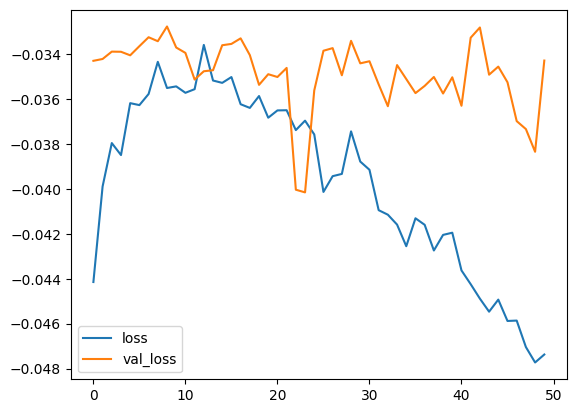

In [19]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

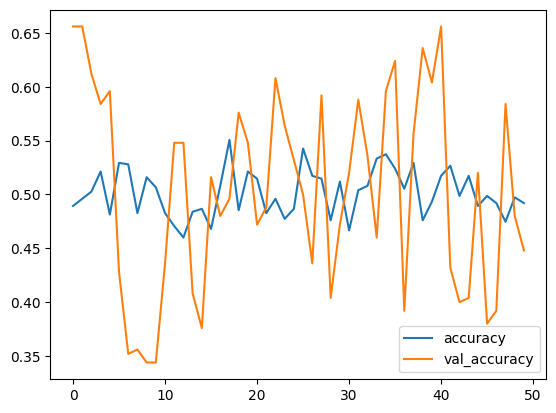

In [20]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [13]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6875 - loss: -0.0413

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6491 - loss: -0.0365 
Validation accuracy of model : 65.60%


In [14]:
prediction = model.predict(np.array([trainX[1]]))
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


array([[0.48392957, 0.5160704 ]], dtype=float32)

In [15]:
trainY[1]

array([-0.04424127,  0.00888849])